## Importations

This notebook is ran in a virtual environment in Ubuntu 20.04.2 LTS

Spark version: spark-2.4.7-bin-hadoop2.7

Java 8 !!!!!!!!!!!!!

In [1]:
import os

Findspark : to use spark within a jupyter notebook

Findspark needs the environment variable SPARK_HOME to work (indicate the spark directory).

In [2]:
# ensure SPARK_HOME is correctly set (in .bashrc)
os.environ['SPARK_HOME']

'/home/maryse/spark-2.4.7-bin-hadoop2.7'

Set the right path to java 8

In [3]:
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"

Import findspark and initialize findspark (allow to use Spark with the notebook)

Makes pyspark available in the jupyter notebook

In [4]:
import findspark
findspark.init()

Sets the environnement variable 'PYSPARK_SUBMIT_ARGS' in order :
- to fetch the databricks sparkdl package, as soon as the pyspark-submit command will be run
- to make Hadoop AWS package available when spark will be loaded

In [5]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell'

Import basic modules

In [6]:
import pandas as pd 
import numpy as np
import cv2

Import pyspark

In [7]:
import pyspark

In [8]:
# # Explore functions of a module
# from inspect import getmembers, isfunction
# print(pd.DataFrame(getmembers(pyspark.sql)))

## Configurations ...

In [9]:
# extraction of AWS access keys from key file

path_cred = os.path.join(os.getcwd(),
            "AWS/AWS_IAM_CREDENTIAL/Maryse_P8_credentials.csv")

with open(path_cred,'r') as f:
        msg = f.read()
          
ID = str(msg).split('\n')[1].split(',')[2]
KEY = str(msg).split('\n')[1].split(',')[3]

# set "temporary" environment variables
os.environ["AWS_ACCESS_KEY_ID"]=ID
os.environ["AWS_SECRET_ACCESS_KEY"]=KEY

... or use the configparser to read the credentials from our awsfile

In [10]:
# import configparser
# config = configparser.ConfigParser()
# config.read(os.path.expanduser("AWS/AWS_IAM_CREDENTIAL"))
# access_id = config.get(aws_profile, "aws_access_key_id") 
# access_key = config.get(aws_profile, "aws_secret_access_key")

Create and set parameters of the Hadoop configuration in order to be able to fetch data in S3.

In [11]:
from pyspark import SparkContext, SparkConf

# conf = (SparkConf().set('spark.executor.extraJavaOptions',
#                         '-Dcom.amazonaws.services.s3.enableV4=true')\
#          .set('spark.driver.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true'))

# sc = SparkContext(conf=conf)
sc = SparkContext.getOrCreate() #conf=conf)
# sc.setSystemProperty('com.amazonaws.services.s3.enableV4',
#                      'true')

hadoop_conf=sc._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3.impl",
                "org.apache.hadoop.fs.s3native.NativeS3FileSystem")
hadoop_conf.set("fs.s3.awsAccessKeyId", ID)
hadoop_conf.set("fs.s3.awsSecretAccessKey", KEY)

# hadoopConf = sc._jsc.hadoopConfiguration()
# hadoopConf.set('fs.s3a.awsAccessKeyId', ID)
# hadoopConf.set('fs.s3a.awsSecretAccessKey', KEY)
# hadoopConf.set('fs.s3a.endpoint', 's3-us-east-2.amazonaws.com')
# hadoopConf.set('com.amazonaws.services.s3a.enableV4', 'true')
# hadoopConf.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')

## Instantiation of SparkContext and import sparkdl

Let's instantiate our SparkContext

In [12]:
# # SparkContext become useless if SparkSession (spark.sql) is created
# from pyspark import SparkContext, SparkConf

In [13]:
# # En cas de pbe lié aux serveurs S3 choisis
# conf = (SparkConf().set('spark.executor.extraJavaOptions',
#                         '-Dcom.amazonaws.services.s3.enableV4=true')\
#                    .set('spark.driver.extraJavaOptions',
#                         '-Dcom.amazonaws.services.s3.enableV4=true'))

In [14]:
# # Default SparkContext
# sc = SparkContext()

# # # Custom SparkContext
# # sc=SparkContext(conf=conf)
# # sc.setSystemProperty('com.amazonaws.services.s3.enableV4',
# #                      'true')

In [15]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('FeatExtr').getOrCreate()

Then only we import sparkdl

In [16]:
import warnings
# show only one warning if multiple warnings in the same cell
warnings.filterwarnings("ignore") # "once"

import sparkdl

Using TensorFlow backend.


## Create a Spark DataFrame containing all the pictures

### Read images and vectorize

In [17]:
from pyspark.ml.image import ImageSchema

Reads recursively all images in the specified directory, put in a Spark DataFrame

In [18]:
# Option1: Get local data

data_path = "./DATA/fruits-360/SAMPLE" # /Corn"
    
# Option2: Get data from s3

# bucket='ocfruitpictures'
# # folder = 'SAMPLE'
# folder = 'Training'
# data_path = 's3://{}/{}'.format(bucket, folder)

In [19]:
# reads all images contained in the directory

images_df = ImageSchema.readImages(data_path,
                                   recursive=True)

Show the content of the Spark DataFrame

In [20]:
# images_df.show()

In [21]:
# images_df.printSchema()

Now we've got a Spark DataFrame containing all the images, each as one row.

### Display sample picture

Extract first picture

In [22]:
# # extract first row of the DataFrame
# row0 = images_df.first()

In [23]:
# row0.asDict()['image']['mode']

In [24]:
# # transform the row in a dict, and turn the data in a 1D np.array
# mat0 = np.array(row0.asDict()['image']['data'])
# # reshape the 1D vector into a 3 channel, 2D np.array of pixels
# mat0 = mat0.reshape(100, 100, 3)[:, :, ::-1] # reverse BGR to RGB
# mat0.shape

In [25]:
# from PIL import Image
# # Display sample image
# Image.fromarray(mat0, 'RGB')

## Features extraction (Transfer Learning) using Sparkdl

In [26]:
from sparkdl import DeepImageFeaturizer

In [27]:
# Instantiation of the featurizer
feat = DeepImageFeaturizer(inputCol="image",
                           outputCol="image_features",
                           modelName="ResNet50")

Instantiation of a sparkdl pipeline to process the image data

In [28]:
from pyspark.ml import Pipeline

pipe = Pipeline(stages=[feat])
extractor = pipe.fit(images_df)

In [29]:
ext_features_df = extractor.transform(images_df)
# ext_features_df.printSchema()

In [30]:
# ext_features_df.show()

In [31]:
# # compare the size of the Spark DataFrame (prior action)
# # and that of a Pandas DataFrame

# import sys
# print(sys.getsizeof(ext_features_df),
#       sys.getsizeof(ext_features_df.toPandas()))

## PCA on the extracted features

In [32]:
from pyspark.ml.feature import PCA

# instantiate Spark PCA model
pca = PCA(k=8,
          inputCol="image_features",
          outputCol="pca_features")

In [33]:
# fit the model on the extracted features
model = pca.fit(ext_features_df.select('image_features'))

In [34]:
# cumulative explained variance
cumValues = model.explainedVariance.cumsum()

Text(0, 0.5, 'Cumulative explained variance')

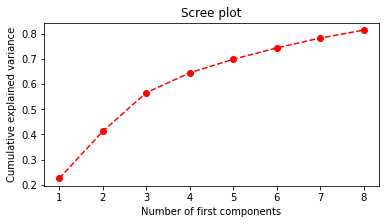

In [35]:
import matplotlib.pyplot as plt

# show the scree plot
plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(6,3))
plt.plot(range(1,9), cumValues, color='r',
         marker = 'o', linestyle='--')
plt.title('Scree plot')
plt.xlabel('Number of first components')
plt.ylabel('Cumulative explained variance')

In [36]:
# get the projection of the extracted features using PCA

pca_feat_df = model.transform(ext_features_df)
pca_feat_df.show(truncate=True)

+--------------------+--------------------+--------------------+
|               image|      image_features|        pca_features|
+--------------------+--------------------+--------------------+
|[file:/home/marys...|[0.24925154447555...|[-12.529673163011...|
|[file:/home/marys...|[0.45899030566215...|[-11.801572304069...|
|[file:/home/marys...|[2.24640989303588...|[-18.164272505059...|
|[file:/home/marys...|[1.94920766353607...|[-13.197414654339...|
|[file:/home/marys...|[0.53471016883850...|[-15.306634451404...|
|[file:/home/marys...|[0.02559056505560...|[20.2904767252304...|
|[file:/home/marys...|[0.10091863572597...|[17.3329560039164...|
|[file:/home/marys...|[0.13858571648597...|[23.6065910954511...|
|[file:/home/marys...|[0.08605482429265...|[9.20104508968864...|
|[file:/home/marys...|[0.00671436730772...|[16.2469733598572...|
|[file:/home/marys...|[0.06267129629850...|[8.94065403878746...|
|[file:/home/marys...|[0.01391865313053...|[12.0976046936089...|
|[file:/home/marys...|[0.

## Get the class of each image

In [37]:
# # Get class of the sample fruits

orig_col = pca_feat_df['image']['origin']
split_col = pyspark.sql.functions.split(orig_col,
                                        'SAMPLE/')

# add a new "label" column
df_ = pca_feat_df.withColumn('labels',
                                 split_col.getItem(1))
split_col = pyspark.sql.functions.split(df_['labels'],
                                        '/')
df_ = df_.withColumn('labels',
                     split_col.getItem(0))

df_ = df_.withColumnRenamed("image", "path")

df_.show()

+--------------------+--------------------+--------------------+-----------+
|                path|      image_features|        pca_features|     labels|
+--------------------+--------------------+--------------------+-----------+
|[file:/home/marys...|[0.24925154447555...|[-12.529673163011...| Clementine|
|[file:/home/marys...|[0.45899030566215...|[-11.801572304069...| Clementine|
|[file:/home/marys...|[2.24640989303588...|[-18.164272505059...| Clementine|
|[file:/home/marys...|[1.94920766353607...|[-13.197414654339...| Clementine|
|[file:/home/marys...|[0.53471016883850...|[-15.306634451404...| Clementine|
|[file:/home/marys...|[0.02559056505560...|[20.2904767252304...|       Corn|
|[file:/home/marys...|[0.10091863572597...|[17.3329560039164...|       Corn|
|[file:/home/marys...|[0.13858571648597...|[23.6065910954511...|       Corn|
|[file:/home/marys...|[0.08605482429265...|[9.20104508968864...|       Corn|
|[file:/home/marys...|[0.00671436730772...|[16.2469733598572...|       Corn|

In [38]:
results_df = df_.select('path','pca_features','labels')

Write final DataFrame in parquet format in S3 Bucket

In [39]:
# import pyarrow.csv as pv
# import pyarrow.parquet as pq

# # results_pd = results_df.toPandas()
# pq.write_table(results_df, 'test1.parquet') # Index(['path', 'pca_features', 'labels'], dtype='object')

In [46]:
# spark.conf.set("spark.sql.parquet.compression.codec", "snappy") # gzip, lzo or lz4
spark.conf.set("spark.sql.parquet.compression.codec", "uncompressed")
# spark.sql("SET parquet.compression=SNAPPY")
# spark.sql("SET spark.sql.parquet.compression.codec=snappy")
# df_.write.parquet("p0.parquet")

In [41]:
# results_pd = results_df.toPandas()

In [47]:
path = "file:///home/maryse/PARTAGE/FORMATION/OCR_DS/PROJET8/P2.parquet"
results_df.write.parquet(path)

Py4JJavaError: An error occurred while calling o257.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:198)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:159)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:81)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:696)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:696)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:696)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:305)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:291)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:249)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:586)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.FileNotFoundException: /home/maryse/PARTAGE/FORMATION/OCR_DS/PROJET8/P2.parquet/_temporary/0/task_20210308175202_0009_m_000000/part-00000-4ef3db71-38ad-4f8e-9c29-d40ef46fd28d-c000.parquet (Aucun fichier ou dossier de ce type)
	at java.io.FileInputStream.open0(Native Method)
	at java.io.FileInputStream.open(FileInputStream.java:195)
	at java.io.FileInputStream.<init>(FileInputStream.java:138)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileInputStream.<init>(RawLocalFileSystem.java:106)
	at org.apache.hadoop.fs.RawLocalFileSystem.open(RawLocalFileSystem.java:202)
	at org.apache.hadoop.fs.FileSystem.open(FileSystem.java:769)
	at org.apache.hadoop.fs.FileUtil.copy(FileUtil.java:364)
	at org.apache.hadoop.fs.FileUtil.copy(FileUtil.java:338)
	at org.apache.hadoop.fs.FileUtil.copy(FileUtil.java:289)
	at org.apache.hadoop.fs.RawLocalFileSystem.rename(RawLocalFileSystem.java:374)
	at org.apache.hadoop.fs.ChecksumFileSystem.rename(ChecksumFileSystem.java:613)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.mergePaths(FileOutputCommitter.java:414)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.mergePaths(FileOutputCommitter.java:428)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:362)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:334)
	at org.apache.parquet.hadoop.ParquetOutputCommitter.commitJob(ParquetOutputCommitter.java:48)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:166)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:187)
	... 33 more


In [ ]:
# path = "/home/maryse/PARTAGE/FORMATION/OCR_DS/PROJET8/P0.json"
# results_df.write.json('truc')

In [ ]:
# results_df.write.parquet("s3://ocfruitpictures/RESULTS_all")